# 03 - Text Preprocessing

This notebook preprocesses the cleaned text data for topic modeling.

## Preprocessing Steps
- Text cleaning (case, punctuation, numbers)
- Tokenization
- Stopword removal (Indonesian + English)
- Stemming with PySastrawi (with performance tracking)
- Bigram/Trigram phrase detection
- Save processed corpus

In [19]:
# Import required libraries
import sys
import time
import pickle
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.config import get_settings, ensure_directories
from src.preprocessor import IndonesianPreprocessor

In [20]:
# Load settings and data
settings = get_settings()
ensure_directories(settings)

data_path = settings.processed_data_dir / settings.clean_metadata_file
print(f"Loading cleaned data from: {data_path}")

df = pd.read_csv(data_path)
print(f"Loaded {len(df):,} records")

Loading cleaned data from: c:\Users\alifn\Code\topic-modeling-utama\data\processed\clean_metadata.csv
Loaded 12,054 records


## 1. Initialize Preprocessor

In [21]:
# Configuration
USE_STEMMING = settings.use_stemming  # Set to False to skip stemming (much faster)
USE_BIGRAMS = settings.use_bigrams
USE_TRIGRAMS = settings.use_trigrams

# Custom stopwords (domain-specific)
CUSTOM_STOPWORDS = {
    # Academic terms that appear in most papers
    # "hal", "memiliki", "sebesar", "menunjukan", "salah", "tujuan", "penulis", "disimpulkan", "besar", "tingakt",
    # "pengaruh", "berpengaruh", "signifikan", "variabel", "nilai", "parsial", "simultan", "uji", "sampel", "populasi",
    # "deskriptif", "hubungan", "periode", "perhitungan", "positif", "responden", "menganalisis", "independen", "hipotesis",
    # "pengujian", "diterima", "teknik", "meningkatkan", "pelaksanaan", "proses", "tingkat", "besarnya", "sesuai", "faktor",
    # "jenis", "penerapan", "aktivitas", "bandung", "kota", "indonesia", "daerah", "perusahaan", "mempengaruhi", "diharapkan",
    # "dilaksanakan", "objek", "verifikatif", "langsung", "orang", "kegiatan", "kondisi", 'efektif', 'efektivitas', 
    # 'memadai', 'peningkatan', 'kebutuhan', 'kontribusi', 'program', 'dependen', 'statistik', 'menguji', 'menentukan', 'kuat',
    # 'penggunaan', 'bentuk', 'alat', 'membantu', 'mencapai', 'menghasilkan', 'kerja', 'masyarakat', 'diuji', 'model',
    # 'utama', 'diterapkan', 'pengelolaan', 'penilaian', 'pengendalian', 'diteliti', 'kategori', 'peranan', 'kemampuan',
    # 'internal', 'kualitas', 'manusia', 'studi', 'melaksanakan', 'perkembangan', 'pengolahan', 'pendekatan', 'pengumpulan',
    # 'fungsi', 'unit', 'kuantitatif', 'kuesioner', 'diambil', 'research', 'company', 'study', 'test', 'value', 'variable', 
    # 'using', 'method', 'performance', 'mahasiswa', 'used', 'customer', 'product', 'good', 'influence', 'process', 'based', 
    # 'one', 'means', 'service', 'analysis', 'time', 'effect', 'results', 'business', 'marketing', 'brand_image', 'variable', 
    # 'dimension', 'universitas', 'widyatama', 'barat', 'kabupaten', 'dinas', 'kota', 'teori', 'ditemukan', 'makna', 'dibandingkan',
    # 'menunjang', 'berperan', 'berjalan', 'dibutuhkan', 'terdaftar', 'mengidentifikasi', 'mendeskripsikan', 'dianalisis', 'skripsi',
    # 'berjudul', 'quality', 'karya', 'tipe', 'score', 'prosedur', 'tugas', 'praktik', 'perbedaan', 'provinsi', 'jawa', 'barat',
    # 'video', 'employees', 'management', 'information', 'descriptive', 'meaning', 'companies', 'novel', 'kalimat', 'kamar', 'inti', 'divisi', 'dunia',
    # 'system', 'brand_image', 'bank_mandiri', 'telkom', 'pos_persero', 'pdam', 'jepang',
    # 1. Kata Umum (General Stopwords)
    'hal', 'salah', 'memiliki', 'sebesar', 'nilai', 'tingkat', 
    'inti', 'jenis', 'makna', 'ditemukan', 'membantu', 'meningkatkan',
    'aspek', 'besar', 'kecil', 'utama', 'unit', 'faktor', 'dimensi',
    
    # 2. Statistik & Judul (Statistical Terms) - WAJIB HAPUS
    'pengaruh', 'berpengaruh', 'signifikan', 'berpengaruh_signifikan',
    'variabel', 'variabel_independen', 'variabel_dependen',
    'parsial', 'simultan', 'uji', 'sampel', 'populasi', 'hipotesis',
    'menunjukan', 'hubungan', 'perbedaan', 'diterima', 'ditolak',
    'deskriptif', 'periode', 'data', 'rata_rata', 'koefisien',
    
    # 3. Akademik & Metodologi (Academic Boilerplate)
    'penulis', 'tujuan', 'teori', 'skripsi_berjudul', 'menganalisis',
    'studi', 'program_studi', 'universitas', 'perguruan', 'mahasiswa',
    'metode', 'teknik', 'proses', 'prosedur', 'pelaksanaan', 'penerapan',
    'kegiatan', 'pengelolaan', 'perhitungan', 'penilaian', 'evaluasi',
    'laporan', 'pencatatan', 'perancangan',
    
    # 4. Lokasi & Entitas (Location & Entities)
    'indonesia', 'bandung', 'kota_bandung', 'jawa_barat', 'daerah',
    'tbk', 'persero', 'pt', 'cv', 'jalan',
    
    # 5. Bahasa Inggris (English Leaks)
    'research', 'company', 'test', 'using', 'value', 'influence', 
    'analysis', 'based', 'performance', 'method', 'study', 'product', 
    'process', 'service', 'management', 'system'
}

print(f"Configuration:")
print(f"  Stemming: {USE_STEMMING}")
print(f"  Bigrams: {USE_BIGRAMS}")
print(f"  Trigrams: {USE_TRIGRAMS}")
print(f"  Custom stopwords: {len(CUSTOM_STOPWORDS)}")

Configuration:
  Stemming: False
  Bigrams: True
  Trigrams: True
  Custom stopwords: 92


In [22]:
# Initialize preprocessor
preprocessor = IndonesianPreprocessor(
    settings=settings,
    custom_stopwords=CUSTOM_STOPWORDS,
    use_stemming=USE_STEMMING,
    use_bigrams=USE_BIGRAMS,
    use_trigrams=USE_TRIGRAMS,
)

print(f"Total stopwords: {len(preprocessor.stopwords)}")

INFO:src.preprocessor:Built stopwords set with 1467 words
INFO:src.preprocessor:Preprocessor initialized (stemming=False)


Total stopwords: 1467


## 2. Test Preprocessing on Sample

In [23]:
# Test on a sample abstract
sample_idx = df[df['abstract'].str.len() > 200].sample(1).index[0]
sample_text = df.loc[sample_idx, 'abstract']

print("Sample Abstract:")
print("-" * 60)
print(sample_text[:500] + "..." if len(sample_text) > 500 else sample_text)

Sample Abstract:
------------------------------------------------------------
This research analyzes the running of stocks in companies which have been doing Initial Public Offering (IPO) in Indonesia Bursary Effect during the period of 2010. Measuring the running of stocks is a way to relate the aim of the companies which is to get some fund used for expansion and the aim of the investors which is to get a high return value. This research aims to reveal how short term stocks (for 3 months) and long term stocks (for 24 months) are run in the companies which have been doin...


In [24]:
# Preprocess sample
start_time = time.time()
sample_tokens = preprocessor.preprocess_text(sample_text, apply_phrases=False)
elapsed = time.time() - start_time

print(f"\nPreprocessed tokens ({len(sample_tokens)} tokens, {elapsed:.3f}s):")
print("-" * 60)
print(sample_tokens[:30])
if len(sample_tokens) > 30:
    print(f"... and {len(sample_tokens) - 30} more")


Preprocessed tokens (101 tokens, 0.002s):
------------------------------------------------------------
['analyzes', 'running', 'stocks', 'companies', 'initial', 'public', 'offering', 'ipo', 'bursary', 'effect', 'period', 'measuring', 'running', 'stocks', 'way', 'relate', 'aim', 'companies', 'get', 'fund', 'used', 'expansion', 'aim', 'investors', 'get', 'high', 'return', 'aims', 'reveal', 'short']
... and 71 more


## 3. Process All Documents

In [25]:
# Get abstracts
abstracts = df['abstract'].fillna('').tolist()

print(f"Processing {len(abstracts):,} documents...")
print(f"This may take a while, especially with stemming enabled.")
print("-" * 60)

Processing 12,054 documents...
This may take a while, especially with stemming enabled.
------------------------------------------------------------


In [26]:
# Process all documents
start_time = time.time()

processed_docs = preprocessor.preprocess_documents(
    abstracts,
    fit_phrases=USE_BIGRAMS or USE_TRIGRAMS,
    show_progress=True,
)

total_time = time.time() - start_time
print(f"\n✅ Preprocessing complete in {total_time:.1f}s")

INFO:src.preprocessor:Preprocessing 12054 documents...
Preprocessing: 100%|██████████| 12054/12054 [00:07<00:00, 1564.13it/s]
INFO:src.preprocessor:Fitting bigram model...
INFO:gensim.models.phrases:collecting all words and their counts
INFO:gensim.models.phrases:PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO:gensim.models.phrases:PROGRESS: at sentence #10000, processed 943473 words and 366211 word types
INFO:gensim.models.phrases:collected 419296 token types (unigram + bigrams) from a corpus of 1132466 words and 12014 sentences
INFO:gensim.models.phrases:merged Phrases<419296 vocab, min_count=20, threshold=10, max_vocab_size=40000000>
INFO:gensim.utils:Phrases lifecycle event {'msg': 'built Phrases<419296 vocab, min_count=20, threshold=10, max_vocab_size=40000000> in 0.88s', 'datetime': '2025-12-13T03:54:10.367354', 'gensim': '4.4.0', 'python': '3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26200-SP


✅ Preprocessing complete in 12.3s


In [27]:
# Display statistics
stats = preprocessor.stats

print("\nPreprocessing Statistics:")
print("=" * 50)
print(f"Total documents:      {stats.total_documents:,}")
print(f"Processed documents:  {stats.processed_documents:,}")
print(f"Skipped documents:    {stats.skipped_documents:,}")
print(f"Total tokens:         {stats.total_tokens:,}")
print(f"Unique tokens:        {stats.unique_tokens:,}")
print(f"Avg tokens/doc:       {stats.avg_tokens_per_doc:.1f}")
print(f"Total time:           {stats.total_time_seconds:.1f}s")
if stats.stemming_time_seconds > 0:
    print(f"Stemming time:        {stats.stemming_time_seconds:.1f}s ({stats.stemming_time_seconds/stats.total_time_seconds*100:.1f}%)")


Preprocessing Statistics:
Total documents:      12,054
Processed documents:  12,014
Skipped documents:    40
Total tokens:         832,295
Unique tokens:        41,338
Avg tokens/doc:       69.3
Total time:           12.3s


## 4. Analyze Processed Corpus

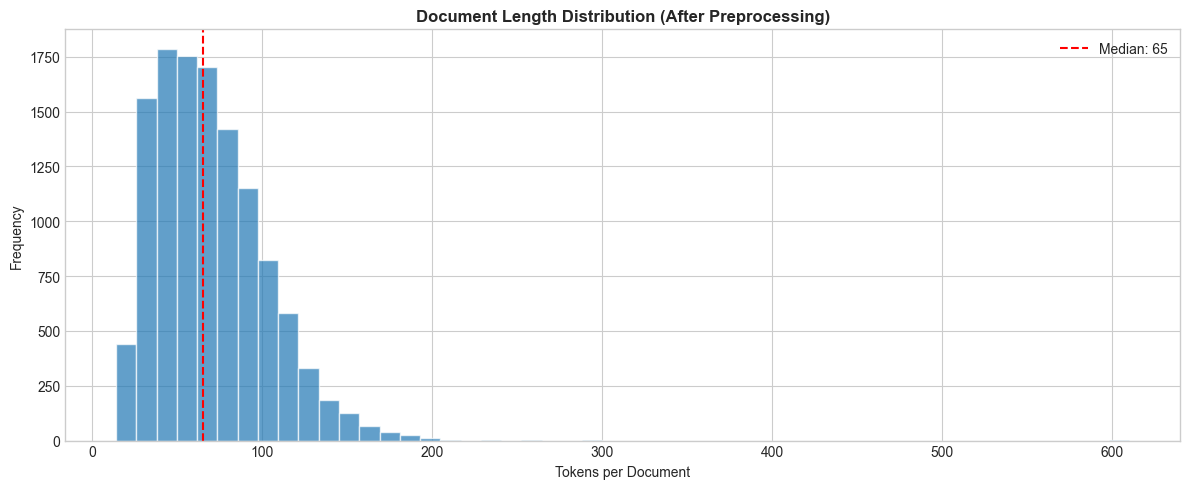

In [28]:
# Token length distribution
token_counts = [len(doc) for doc in processed_docs]

fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(token_counts, bins=50, edgecolor='white', alpha=0.7)
ax.axvline(np.median(token_counts), color='red', linestyle='--',
           label=f'Median: {np.median(token_counts):.0f}')
ax.set_xlabel('Tokens per Document')
ax.set_ylabel('Frequency')
ax.set_title('Document Length Distribution (After Preprocessing)', fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

In [29]:
# Top tokens after preprocessing
all_tokens = [token for doc in processed_docs for token in doc]
token_freq = Counter(all_tokens)

print(f"\nTop 50 tokens after preprocessing:")
print("-" * 50)
for token, count in token_freq.most_common(50):
    print(f"  {count:6d}: {token}")


Top 50 tokens after preprocessing:
--------------------------------------------------
   25284: perusahaan
    4698: karyawan
    4591: keuangan
    4044: kinerja
    3338: sistem
    3081: produk
    2786: positif
    2710: kota
    2691: konsumen
    2591: penjualan
    2469: kinerja_karyawan
    2448: pengujian
    2443: informasi
    2078: manajemen
    1928: produksi
    1857: responden
    1822: biaya
    1809: pajak
    1801: bank
    1678: kualitas
    1618: sesuai
    1603: kualitas_pelayanan
    1594: kerja
    1589: besarnya
    1535: independen
    1511: pegawai
    1494: mempengaruhi
    1475: harga_saham
    1429: diharapkan
    1396: pemerintah
    1385: usaha
    1365: audit_internal
    1361: profitabilitas
    1359: aplikasi
    1358: masyarakat
    1347: jasa
    1300: organisasi
    1247: disimpulkan
    1243: aktivitas
    1227: verifikatif
    1201: memadai
    1199: kondisi
    1193: program
    1173: orang
    1171: efektif
    1171: pelayanan
    1168: kontrib

In [30]:
# Check for bigrams/trigrams
phrases = [t for t in token_freq if '_' in t]
print(f"\nDetected phrases (bigrams/trigrams): {len(phrases)}")

if phrases:
    print("\nTop 20 phrases:")
    phrase_counts = {p: token_freq[p] for p in phrases}
    for phrase, count in sorted(phrase_counts.items(), key=lambda x: -x[1])[:20]:
        print(f"  {count:5d}: {phrase}")


Detected phrases (bigrams/trigrams): 6149

Top 20 phrases:
   2469: kinerja_karyawan
   1603: kualitas_pelayanan
   1475: harga_saham
   1365: audit_internal
   1159: pengendalian_internal
    933: kinerja_keuangan
    875: sistem_informasi_akuntansi
    816: auditor_internal
    805: sumber_daya_manusia
    777: kualitas_produk
    736: sistem_informasi
    714: motivasi_kerja
    693: return_saham
    689: wajib_pajak
    615: keputusan_pembelian
    587: loyalitas_konsumen
    587: good_corporate_governance
    584: kepuasan_konsumen
    573: kinerja_pegawai
    566: terdaftar_bursa_efek


## 5. Create DataFrame with Tokens

In [31]:
# Filter original dataframe to match processed documents
# (some documents may have been skipped due to short length)

# Find valid indices
valid_indices = []
doc_idx = 0

for i, abstract in enumerate(abstracts):
    tokens = preprocessor.preprocess_text(abstract, apply_phrases=False)
    if len(tokens) >= settings.min_doc_length:
        valid_indices.append(i)

# Create result dataframe
df_processed = df.iloc[valid_indices].copy().reset_index(drop=True)
df_processed['tokens'] = processed_docs
df_processed['token_count'] = [len(doc) for doc in processed_docs]

print(f"Processed dataframe: {len(df_processed):,} records")

Processed dataframe: 12,014 records


In [32]:
# Preview
df_processed[['title', 'token_count', 'tokens']].head()

,title,token_count,tokens
0,PENGARUH BUDAYA KESELAMATAN DAN KESEHATAN KERJ...,78,"[budaya, keselamatan_kesehatan_kerja, produkti..."
1,Pengaruh Kompensasi terhadap Motivasi Kerja Ka...,88,"[skripsi_disusun, andri, tanjung, nrp, judul, ..."
2,PERANAN SISTEM INFORMASI AKUNTANSI DALAM MENUN...,178,"[organisasi, didirikan, mencapai, mencari, lab..."
3,PENGARUH USIA DAN MASA KERJA TERHADAP PRODUKTI...,57,"[usia, kerja, produktivitas, pegawai, packer, ..."
4,PENGARUH SISTEM PENGENDALIAN INTERNAL PEMERINT...,38,"[sistem_pengendalian_internal, pemerintah, kua..."


## 6. Save Processed Data

In [33]:
# Save processed corpus
corpus_path = settings.processed_data_dir / settings.processed_corpus_file

corpus_data = {
    'documents': processed_docs,
    'dataframe': df_processed,
    'stats': preprocessor.stats,
}

with open(corpus_path, 'wb') as f:
    pickle.dump(corpus_data, f)

print(f"✅ Saved processed corpus to: {corpus_path}")

✅ Saved processed corpus to: c:\Users\alifn\Code\topic-modeling-utama\data\processed\processed_corpus.pkl


In [34]:
# Save preprocessor (for consistent preprocessing of new text)
preprocessor_path = settings.processed_data_dir / 'preprocessor.pkl'
preprocessor.save(preprocessor_path)
print(f"✅ Saved preprocessor to: {preprocessor_path}")

INFO:src.preprocessor:Saved preprocessor to c:\Users\alifn\Code\topic-modeling-utama\data\processed\preprocessor.pkl


✅ Saved preprocessor to: c:\Users\alifn\Code\topic-modeling-utama\data\processed\preprocessor.pkl


In [35]:
# Also save as CSV (without tokens for readability)
csv_path = settings.processed_data_dir / 'processed_metadata.csv'
df_processed.drop(columns=['tokens']).to_csv(csv_path, index=False)
print(f"✅ Saved metadata CSV to: {csv_path}")

✅ Saved metadata CSV to: c:\Users\alifn\Code\topic-modeling-utama\data\processed\processed_metadata.csv


## Summary

In [36]:
print("\n" + "=" * 60)
print("PREPROCESSING COMPLETE")
print("=" * 60)
print(f"\n📊 Documents processed: {len(processed_docs):,}")
print(f"📝 Unique tokens: {stats.unique_tokens:,}")
print(f"📈 Avg tokens/doc: {stats.avg_tokens_per_doc:.1f}")
print(f"⏱️  Total time: {stats.total_time_seconds:.1f}s")

print(f"\n📁 Output files:")
print(f"   - {corpus_path}")
print(f"   - {preprocessor_path}")
print(f"   - {csv_path}")

print(f"\n👉 Next: Run 04_lda_modeling.ipynb to train the LDA model")


PREPROCESSING COMPLETE

📊 Documents processed: 12,014
📝 Unique tokens: 41,338
📈 Avg tokens/doc: 69.3
⏱️  Total time: 12.3s

📁 Output files:
   - c:\Users\alifn\Code\topic-modeling-utama\data\processed\processed_corpus.pkl
   - c:\Users\alifn\Code\topic-modeling-utama\data\processed\preprocessor.pkl
   - c:\Users\alifn\Code\topic-modeling-utama\data\processed\processed_metadata.csv

👉 Next: Run 04_lda_modeling.ipynb to train the LDA model
